In [207]:
from graphviz import Digraph, nohtml
from bisect import insort_left, bisect_left
from math import floor
from random import randint

# Arbres-B - Version 1
Sources : Cours d'AlgAv et Sedgewick Wayne - Algorithms 4th edition

Pour un arbre d'ordre m:
- Noeuds : m <= k <= 2m clés
- Racine : 1 <= k <= 2m clés

# Table des matières <a class="anchor" id="menu"></a>
* [Graphviz](#graphviz)
* [Arbre-B et PageB V1](#btree1)
* [Tests](#tests)
<!-- * [Arbre-B et PageB V2](#btree2) -->

## Graphviz <a class="anchor" id="graphviz"></a>                                                                                                                                  
#### [Retour](#menu) 

In [208]:
def visualiser_arbre(arbreB):
    # dot = Digraph()
    dot = Digraph(node_attr={'shape': 'record', 'height': '.1'})
    index = 0

    def bufferNoeud(cles):
        buffer = "<f0> |"
        for i in range(len(cles)):
            buffer += "<f" + str(2*i+1) + "> " + str(cles[i]) + "|" # case cle : indice impair
            if i != len(cles)-1:
                buffer += "<f" + str(2*i+2) + "> " + "|" # case pointeur vers enfant : indice pair
            else:
                buffer += "<f" + str(2*i+2) + "> "
        return buffer

        # for i in range(1,nbCases):
        #     if i % 2 == 1: # cle
        #         buffer += "<f" + str(i) + "> " + str(cles[i]) + "|"
        #     else:
        #         buffer += "<f" + str(i) + "> " + "|"
        # # buffer += "<f" + str(nbCases) + "> " + str(cles[-1]) # derniere cle sans le "|"
        # return buffer


        # if cle is None:
        #     buffer += "<f" + str(indice) + "> "
        # else:
        #     buffer += "<f" + str(indice) + "> " + str(cle)
        # if not estDerniereCle:
        #     buffer += "|"
        # return buffer
    
    def traverse(pageB):
        nonlocal index

        if pageB is None:
            return

        buffer = bufferNoeud(pageB.cles)
        dot.node(str(index), nohtml(buffer))
        # index += 1
        
        idParent = index
        for i in range(len(pageB.enfants)):
            parent = str(idParent) + ":f" + str(2*i)
            index += 1
            enfant = str(index)
            dot.edge(parent, enfant)
            traverse(pageB.enfants[i])
    
    traverse(arbreB.racine)
    return dot

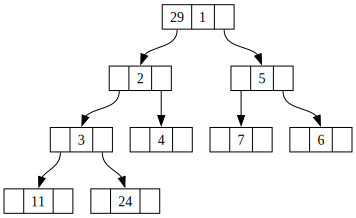

In [209]:
# test graphviz - source : https://graphviz.readthedocs.io/en/stable/examples.html#btree-py

g = Digraph(node_attr={'shape': 'record', 'height': '.1'})

g.node('node0', nohtml('<f0> 29|<f1> 1|<f2>'))
g.node('node1', nohtml('<f0> |<f1> 2|<f2>'))
g.node('node2', nohtml('<f0> |<f1> 3|<f2>'))
g.node('node3', nohtml('<f0> |<f1> 4|<f2>'))
g.node('node4', nohtml('<f0> |<f1> 5|<f2>'))
g.node('node5', nohtml('<f0> |<f1> 7|<f2>'))
g.node('node6', nohtml('<f0> |<f1> 6|<f2>'))
g.node('node7', nohtml('<f0> |<f1> 11|<f2>'))
g.node('node8', nohtml('<f0> |<f1> 24|<f2>'))

g.edge('node0:f2', 'node4:f1')
g.edge('node0:f0', 'node1:f1')
g.edge('node1:f0', 'node2:f1')
g.edge('node1:f2', 'node3:f1')
g.edge('node2:f2', 'node8:f1')
g.edge('node2:f0', 'node7:f1')
g.edge('node4:f2', 'node6:f1')
g.edge('node4:f0', 'node5:f1')

g

## Arbre-B et PageB <a class="anchor" id="btree"></a>                                                                                                                                  
#### [Retour](#menu) 

In [210]:
class PageB:
    def __init__(self, cles:'list'=[]):
        self.cles = cles # nbCles noeud : entre m et 2m, nbCles racine : entre 1 et 2m
        self.enfants = []
        self.parent = None
        # self.estExterne = estExterne

    def _estPageVide(self): # peut-etre utile ?
        return self.cles == []

    def _estPageExterne(self): # ajouter des underscore pour les fonctions auxiliaires
        """ Retourne true si self est une page externe (feuille).
        """
        return len(self.enfants) == 0
    
    def _estPageDebordement(self, nbMaxCles):
        """ Retourne true si la page self depasse sa limite de cles (2*ordre).    
        """
        return len(self.cles) > nbMaxCles
    
    def _est_suppression_sans_deficit(self, nbMinCles):
        """ Retourne true si la suppression d'une cle de la page self n'entraine pas
            de deficit en cle ie. si len(self.cles) > nbMinCles (racine : minimum 1 cle
            et noeud : minimum m cles, avec m = ordre de l'arbreB).
        """
        if self.parent is None: # racine : nbCles min = 1 -> cas utile ?
            return len(self.cles) > 1
        else: # noeud : nbCles min = m
            return len(self.cles) > nbMinCles
    
    def _est_page_en_deficit(self, nbMinCles):
        """ Retourne true si la page self est en deficit de cle ie. si len(self.cles) < nbMinCles.
        """
        if self.parent is None: # racine : nbCles min = 1
            return len(self.cles) < 1
        else: # noeud : nbCles min = m
            return len(self.cles) < nbMinCles

    def _recherchePage(self, cle):
        """ Retourne true si cle est dans la page self.
        """
        return cle in self.cles
    
    def _indicePageSuivante(self, cle):
        """ Retourne l'indice de la page suivante (enfant de la page self) qui pourrait
            contenir la cle cle.
            Hypothese : self n'est pas une page externe (sinon pas de page suivante)
            (hypothese verifiee dans la fonction _recherche(arbreB, pageB, cle))
        """
        assert not self._estPageExterne(), "indicePageSuivante : self est une page externe, pas de page suivante!"
        indice = bisect_left(self.cles, cle)
        print(self.cles, cle)
        return indice
    
    def _frereGauche(self) -> 'PageB':
        """ Retourne le frere gauche de la page self s'il existe,
            None si self ne possede pas frere gauche (self est
            la racine ou l'enfant le plus a gauche de son parent).
        """
        if self.parent is None: # self est la racine : pas de frere
            return None
        else:
            indice = self.parent.enfants.index(self) # indice de self parmi les enfants de son parent
            if indice == 0: # pas de frere gauche
                return None
            else:
                return self.parent.enfants[indice - 1]
            
    def _frereDroit(self) -> 'PageB':
        """ Retourne le frere droit de la page self s'il exitse,
            None si self ne possede pas de frere droit (self est
            la racine ou l'enfant le plus a droite de son parent).
        """
        if self.parent is None: # self est la racine : pas de frere
            return None
        else:
            indice = self.parent.enfants.index(self) # indice de self parmi les enfants de son parent
            if indice == len(self.parent.enfants) - 1: # pas de frere droit
                return None
            else:
                return self.parent.enfants[indice + 1]

    def _emprunter_cle_frere(self, frere:'PageB', estGauche:bool):
        """ Emprunte une cle a son frere gauche ou droit. Echange la
            cle avec une cle du parent pour respecter l'ordre des cles.
            Hypothese : l'emprunt d'une cle a son frere n'entraine pas
            de deficit (le possible deficit de cle du parent n'est pas
            traite dans cette fonction mais en dehors).
        """
        if estGauche:
            cleEmpruntee = frere.cles.pop(len(frere.cles)-1)
            indice = self.parent.enfants.index(frere) # gauche -> indice cle enfant gauche
        else:
            cleEmpruntee = frere.cles.pop(0)
            indice = self.parent.enfants.index(self) # droite -> indice cle enfant self
        cleParent = self.parent.cles.pop(indice) # parent echange cle pour respecter l'ordre
        self.parent.cles.insert(indice, cleEmpruntee)
        insort_left(self.cles, cleParent) # self recupere cle parent et un enfant


    # def _empruntCleFrereGauche(self, frereGauche:'PageB'):
    #     """ Retourne une cle predecesseur des cles de self, empruntee au frere gauche
    #         (emprunt de la cle max du frere gauche).
    #         Hypothese : l'emprunt d'une cle n'entraine pas de deficit.
    #     """
    #     cleMaxGauche = frereGauche.cles.pop(len(frereGauche.cles)-1)
    #     return cleMaxGauche
        
    # def _empruntCleFrereDroit(self, frereDroit:'PageB'):
    #     """ Retourne une cle sucesseur des cles de self, empruntee au frere droit
    #         (emprunt de la cle min du frere droit).
    #         Hypothese : l'emprunt d'une cle n'entraine pas de deficit.
    #     """
    #     cleMinDroit = frereDroit.cles.pop(0)
    #     return cleMinDroit

    def _est_emprunt_possible(self, frereGauche:'PageB', frereDroit:'PageB', nbMinCles):
        if frereGauche is None and frereDroit is None: # pas de frere : emprunt impossible
            return False
        # sinon, au moins un des freres est pas None
        # si gauche None alors droit pas None (gauche impossible -> depend de droit)
        if frereGauche is None:
            return frereDroit._est_suppression_sans_deficit(nbMinCles)
        # sinon, gauche pas None et droit None -> depend de gauche
        else:
            return frereGauche._est_suppression_sans_deficit(nbMinCles)

    def _ajoutPageExterne(self, cle):
        """ Ajoute la cle cle dans la page externe self.
        """
        assert self._estPageExterne(), "ajoutPageExterne : pas une page externe!"
        # self.cles.append(cle)
        # self.cles.sort()
        insort_left(self.cles, cle)

    def _eclatement(self):
        """ Eclate la page courante self en deux pages. La cle mediane est
            recuperee par le parent de self et les enfants de self sont
            partages entre les deux nouvelles pages.
            Si self n'a pas de parent (cas de la racine), une nouvelle
            racine est creee.
            Retourne soit le parent de self, soit la nouvelle racine.
            Hypothese : eclatement si len(self.cles) > 2*ordre (debordement)
        """
        # Etapes :
        # - eclater self en 2 : clesMoitiesGauche et clesMoitieDroite
        #   en 2 nouvelles pages -> deviennent les enfants du parent de
        #   self (et supprimer self des enfants de son parent)
        # - le parent recupere la cle mediane de self.cles
        # - les enfants de self enfantsGauche et enfantsDroite deviennent
        #   respectivement les enfants de la page associee a 
        #   clesMoitieGauche/Droite (remarque : si self a k cles alors self
        #   a k+1 enfants -> nombre d'enfants donc egal a 2*(ordre+1) -> pair)
        # - cas 1 : self a un parent -> suivre les etapes du dessus
        # - cas 2 : self n'a pas de parent car c'est la racine
        #   -> creer une nouvelle racine qui a pour unique
        #      cle la cle mediane et comme enfants les 2 nouvelles pages

        moitie = floor(len(self.cles)/2)
        cleMediane = self.cles[moitie]
        pageMoitieGauche = PageB(self.cles[:moitie]) # indice moitie pas inclus
        pageMoitieDroite = PageB(self.cles[moitie+1:]) # indice moitie+1 inclus

        if not self._estPageExterne(): # nb enfants = nb cles+1
            pageMoitieGauche.enfants = self.enfants[:moitie+1] # les nouvelles pages recuperent
            pageMoitieDroite.enfants = self.enfants[moitie+1:] # les enfants de self
            for page in self.enfants[:moitie+1]:
                page.parent = pageMoitieGauche
            for page in self.enfants[moitie+1:]:
                page.parent = pageMoitieDroite

        if self.parent is None: # self est racine -> creer nv racine
            nvRacine = PageB([cleMediane])
            nvRacine.enfants = [pageMoitieGauche, pageMoitieDroite]
            pageMoitieGauche.parent = nvRacine
            pageMoitieDroite.parent = nvRacine
            self.parent = nvRacine
            return nvRacine
        else: # un parent
            insort_left(self.parent.cles, cleMediane) # le parent recupere cle mediane
            self.parent.enfants.remove(self)
            i = bisect_left(self.parent.cles,pageMoitieGauche.cles[0])
            self.parent.enfants.insert(i, pageMoitieGauche)
            # i = bisect_left(self.parent.cles,pageMoitieDroite.cles[0])
            self.parent.enfants.insert(i+1, pageMoitieDroite)
            pageMoitieGauche.parent = self.parent
            pageMoitieDroite.parent = self.parent
            return self.parent

    def _dupliquePage(self, parent=None):
        """ Retourne le duplique de la page self.
        """
        duplique = PageB(self.cles.copy())
        duplique.parent = parent
        for enfant in self.enfants:
            duplique.enfants.append(enfant._dupliquePage(duplique))
        return duplique


    def _fusionPage(self, frere:'PageB', estGauche:bool):
        """ Fusionne la page self avec une page frere gauche en ajoutant les cles de
            self dans celles de frere. Descend une cle du parent pour respecter
            l'ordre des cles dans l'ArbreB. Recupere les enfants de self et du frere.
            Retourne la page resultante.
        """
        fusion = PageB() # page contenant la fusion des cles de frere et self
        fusion.parent = self.parent
        indice = -1
        if estGauche:
            # recuperer l'indice de la cle du parent a descendre (celle entre frere gauche et self)
            indice = fusion.parent.enfants.index(frere) # gauche -> indice cle enfant gauche
            cleParent = fusion.parent.cles.pop(indice) # cle a descendre (et a supprimer du parent)
            fusion.cles = frere.cles + [cleParent] + self.cles
            fusion.enfants = frere.enfants + self.enfants # recuperer les enfants
        else: # frere droite
            # recuperer l'indice de la cle du parent a descendre (celle entre self et frere droit)
            indice = fusion.parent.enfants.index(self) # droite -> indice cle enfant self
            cleParent = fusion.parent.cles.pop(indice) # cle a descendre (et a supprimer du parent)
            fusion.cles = self.cles + [cleParent] + frere.cles
            fusion.enfants = self.enfants + frere.enfants # recuperer les enfants
        # print("fusion : indice !", indice, "et len du parent !", len(fusion.parent.cles))
        fusion.parent.enfants.remove(self) # retirer self des enfants du parent
        fusion.parent.enfants.remove(frere) # retirer frere des enfants du parent
        fusion.parent.enfants.insert(indice, fusion) # ajouter la page resultante dans les enfants du parent
        return fusion
    
    # def _fusionPageDroite(self, frereDroit:'PageB'):
    #     """ Fusionne la page self avec une page frere droit en ajoutant les cles de
    #         self dans celles de frere. Descend une cle du parent pour respecter
    #         l'ordre des cles dans l'ArbreB. Retourne la page resultante.
    #     """
    #     fusion = PageB(self.cles + frereDroit.cles)
    #     fusion.parent = frereDroit.parent
    #     indice = fusion.parent.enfants.index(self)
    #     print("fusion : indice !", indice, "et len du parent !", len(fusion.parent.cles))
    #     cleParent = fusion.parent.cles.pop(indice)
    #     fusion.cles.insert(len(self.cles), cleParent)
    #     fusion.parent.enfants.remove(self)
    #     fusion.parent.enfants.remove(frereDroit)
    #     fusion.parent.enfants.insert(indice, fusion)
    #     return fusion
        

class ArbreB:
    def __init__(self, ordre):
        assert ordre > 0, "ArbreB : veuillez choisir un ordre strictement positif!"
        self.racine = None
        self.ordre = ordre # ordre = nombre de cles min dans un noeud non racine
        self.NBCLESMAX = 2*ordre
    
    def _estVide(self):
        return self.racine is None
    
    def _duplique(self):
        """ Retourne le duplique de l'ArbreB self.
        """
        duplique = ArbreB(self.ordre)
        duplique.racine = self.racine._dupliquePage()
        return duplique
 
    def recherche(self, cle):
        """ Retourne true si cle est dans l'arbre-B self en
            cherchant dans les pagesB de l'arbre-B a l'aide
            de la fonction _recherche(pageB, cle).
        """
        if self._estVide():
            return False
        return self._recherche(self.racine, cle)
    
    def _recherche(self, page:PageB, cle):
        """ Retourne true si la cle est dans l'arbre-B self en
            cherchant si la cle est dans une pageB de l'arbre.
        """
        if page._recherchePage(cle): # cle est dans la page courante
            return True
        else: # sinon continuer a chercher
            if page._estPageExterne(): # pas d'enfant : fin recherche
                return False
            else: # chercher dans la page suivante qui pourrait contenir la cle
                pageSuivante = page.enfants[page._indicePageSuivante(cle)]
                return self._recherche(pageSuivante, cle)


    def ajout(self, cle):
        if self._estVide():
            self.racine = PageB([cle])
        else:
            self._ajout(self.racine, cle)


    def _ajout(self, page:PageB, cle):
        if page._recherchePage(cle): # cle deja dans une page de arbre-B
            return

        if page._estPageExterne(): # page externe (feuille) : ajout ok
            page._ajoutPageExterne(cle)

        else: # ajout dans page suivante (enfant)
            pageSuivante = page.enfants[page._indicePageSuivante(cle)]
            self._ajout(pageSuivante, cle)

        if page._estPageDebordement(self.NBCLESMAX):
            if page.parent is None: # cas augmentation hauteur
                page = page._eclatement()
                self.racine = page # page est devenue la racine
            else:
                page = page._eclatement()

                    

    def suppression(self, cle):
        if self._estVide():
            return
        else:
            self._suppression(self.racine, cle)


    def _suppression(self, page:PageB, cle):
        if page._recherchePage(cle): # on a trouve la cle a supprimer
            if page.parent is None and len(page.cles) == 1: # arbreB = 1 cle a la racine
                self.racine = None
                return
            if page._estPageExterne(): # suppression au niveau d'une feuille : ok
                page.cles.remove(cle)
                # Si suppression entraine un deficit de cles dans la page :
                # emprunter cle predecesseur ou successeur si possible. Le
                # parent recupere la cle empruntee et descend une cle en
                # echange.
                # Sinon, fusionner avec frere gauche et parent descend une cle.
                # Si parent en deficit, parent prend une cle de son frere et un
                # enfant. Si impossible, fusionner avec parent et frere.
                # Si apres emprunt/fusion, parent plus de cle, supprimer noeud vide
                # Si apres emprunt/fusion, parent en deficit, fusion en remontee
                if page._est_page_en_deficit(self.ordre):
                    # un des freres est pas None car cas racine deja traite
                    frereGauche = page._frereGauche()
                    frereDroit = page._frereDroit()
                    if page._est_emprunt_possible(frereGauche, frereDroit, self.ordre):
                        if frereGauche is not None and frereGauche._est_suppression_sans_deficit(self.ordre):
                            page._emprunter_cle_frere(frereGauche, estGauche=True)
                        elif frereDroit is not None and frereDroit._est_suppression_sans_deficit(self.ordre):
                            page._emprunter_cle_frere(frereDroit, estGauche=False)
                    else: # si emprunt impossible -> fusion
                        if frereGauche is not None: # fusion avec gauche
                            page = page._fusionPage(frereGauche, estGauche=True)
                        else: # sinon, fusion avec droit
                            page = page._fusionPage(frereDroit, estGauche=False)
            else: # sinon, suppression pas dans une feuille : echanger cles avec une cle de feuille
                pass
        else:
            if page._estPageExterne():
                print("ArbreB suppression : cle non trouvee dans l'arbreB !")
                return
            pageSuivante = page.enfants[page._indicePageSuivante(cle)]
            self._suppression(pageSuivante, cle)
        # si parent plus de cle apres emprunt/fusion, c'etait la racine -> diminution hauteur
        if page.parent is not None: # page n'est pas la racine -> verifier parent
            if page.parent._estPageVide(): # parent = racine mais pas de cle, cas diminution hauteur
                self.racine = page
                return
            if page.parent._est_page_en_deficit(self.ordre): # emprunt ou fusion
                parentFrereGauche = page.parent._frereGauche()
                parentFrereDroit = page.parent._frereDroit()
                # cas emprunt
                if page.parent._est_emprunt_possible(parentFrereGauche, parentFrereDroit, self.ordre):
                    if parentFrereGauche is not None and parentFrereGauche._est_suppression_sans_deficit(self.ordre):
                        page.parent._emprunter_cle_frere(parentFrereGauche, estGauche=True)
                        # frere gauche doit ceder son dernier enfant au parent
                        enfantFrere = parentFrereGauche.enfants.pop(len(parentFrereGauche.enfants)-1)
                        page.parent.enfants.insert(0, enfantFrere) # enfant frere gauche devient le premier du parent
                    elif parentFrereDroit is not None and parentFrereDroit._est_suppression_sans_deficit(self.ordre):
                        page.parent._emprunter_cle_frere(parentFrereDroit, estGauche=False)
                        enfantFrere = parentFrereDroit.enfants.pop(0) # frere droit cede son premier enfant au parent
                        page.parent.enfants.append(enfantFrere) # enfant frere droit devient le dernier du parent
                else: # cas fusion
                    if parentFrereGauche is not None:
                        page.parent = page.parent._fusionPage(parentFrereGauche, estGauche=True)
                    elif parentFrereDroit is not None:
                        page.parent = page.parent._fusionPage(parentFrereDroit, estGauche=False)

                        
    # def _suppression(self, page:PageB, cle, frereGauche:PageB=None, frereDroit:PageB=None):
    #     # A voir comment gerer frereGauche et frereDroit (a priori utiliser fonctions frereGauche et frereDroit)
    #     print("mes cles !", page.cles)
    #     if page.recherchePage(cle): # on a trouve la cle a supprimer
    #         if page.estPageExterne(): # suppression au niveau d'une feuille : ok
    #             if frereGauche is None and frereDroit is None and len(page.cles) == 1: # arbreB = 1 cle a la racine
    #                 self.racine = None
    #                 return
    #             else:
    #                 # si suppression entraine un deficit de cles dans la page : emprunter cle d'un frere si possible
    #                 # OU on autorise un deficit de cle temporaire comme un debordement de page temporaire
    #                 # pour l'ajout (pour l'eclatement en remontee) ? -> pour l'instant cette version non
    #                 # idee emprunt cle a son frere : avant de supprimer la cle, emprunter la cle max du
    #                 # frere gauche ou la cle min du frere droit, si cela n'entraine pas un deficit de cle
    #                 # dans le frere. Si deficit : fusion avec frere gauche ou droit.
    #                 # Si emprunt ok, le parent descend une cle a la page courante pour respecter l'ordre
    #                 # des cles dans l'arbreB.
    #                 # AUTORISER UN DEFIT TEMPORAIRE ???? pb quand on fusionne et que le parent donne une cle mais
    #                 # apres deficit ou plus de cle !!

        #             if page.estSuppressionSansDeficit(self.ordre): # pas de deficit : suppression ok
        #                 # print("mes cles !", page.cles)
        #                 page.cles.remove(cle) # supprimer la cle de la page courante
        #             else : # suppression entraine un deficit de cle dans la page -> emprunter ou fusionner
        #                 # si emprunt frere gauche ok
        #                 if frereGauche is not None and frereGauche.estSuppressionSansDeficit(self.ordre):
        #                     cleEmprunteeGauche = page.empruntCleFrereGauche(frereGauche, self.ordre)
        #                     page.cles.remove(cle) # supprimer la cle de la page courante
        #                     # A TESTER ICI----------------
        #                     print("j'emprunte la cle à mon frère gauche!", cleEmprunteeGauche)
        #                     indice = bisect_left(page.parent.cles, cleEmprunteeGauche) # verifier si c'est la bonne cle !
        #                     print("indice !", indice, "et len parent !", len(page.parent.cles))
        #                     cleParent = page.parent.cles.pop(indice)
        #                     # ----------------------------
        #                     page.parent.cles.insert(indice, cleEmprunteeGauche) # parent recupere cle empruntee
        #                     # page courante recupere cle parent (cle max frere gauche -> cle min page courante)
        #                     page.cles.insert(0, cleParent)
        #                 # sinon, si emprunt frere droit ok
        #                 elif frereDroit is not None and frereDroit.estSuppressionSansDeficit(self.ordre):
        #                     cleEmprunteeDroit = page.empruntCleFrereDroit(frereDroit, self.ordre)
        #                     page.cles.remove(cle) # supprimer la cle de la page courante
        #                     print("j'emprunte la cle à mon frère droit!", cleEmprunteeDroit)
        #                     indice = bisect_left(page.parent.cles, cleEmprunteeDroit)
        #                     print("indice !", indice, "et len parent !", len(page.parent.cles))
        #                     cleParent = page.parent.cles.pop(indice)
        #                     page.parent.cles.insert(indice, cleEmprunteeDroit)
        #                     page.cles.append(cleParent) # cle min frere droit -> cle max page courante
        #                 else : # emprunt impossible : fusion avec frere gauche ou droit
        #                     # comment savoir si fusion avec frere gauche ou droit ? gauche si possible ?

        #                     # Traiter cas si parent sera en deficit en descendant une cle
        #                     if page.parent is None:
        #                         if page.parent.estSuppressionSansDeficit(self.ordre):
        #                             if frereGauche is not None:
        #                                 page = page.fusionPageGauche(frereGauche)
        #                             else:
        #                                 assert frereDroit is not None, "ArbreB _suppression : erreur, frereDroit est None"
        #                                 page = page.fusionPageDroite(frereDroit)
        #                             page.cles.remove(cle)
        #                         else: # parent = racine = cle unique -> fusion = combiner les cles + nv racine = page resultante
        #                             if frereGauche is not None:
        #                                 page.cles = frereGauche.cles + page.cles
        #                             else:
        #                                 assert frereDroit is not None, "ArbreB _suppression : erreur, frereDroit est None"
        #                                 page.cles = page.cles + frereDroit.cles
        #                             page.cles.remove(cle)
        #                             self.racine = page
        #                     else:
        #                         if page.parent.estSuppressionSansDeficit(self.ordre):
        #                             if frereGauche is not None: # fusion avec frere gauche
        #                                 page = page.fusionPageGauche(frereGauche)
        #                             else: # sinon, fusion avec frere droit
        #                                 assert frereDroit is not None, "ArbreB _suppression : erreur, frereDroit est None"
        #                                 page = page.fusionPageDroite(frereDroit)
        #                             print("mes cles avant remove !", page.cles)
        #                             page.cles.remove(cle)
        #                             print("mes cles apres remove !", page.cles)
        #                             # si fusion + descente d'une cle du parent cause un debordement de la page : eclatement
        #                             if page.estPageDebordement(self.NBCLESMAX):
        #                                 page = page.eclatement()
        #                         else: # parent combinaison avec frere
        #                             # cas combinaison avec frere
                                    
        #                             # sinon combinaison impossible, supprimer parent et fusion page + frere
        #                             pass
        #     else: # la cle a supprimer n'est pas dans une feuille : echanger cles avec une cle de feuille ??
        #         pass
        # else: # sinon continuer de chercher la cle a supprimer
        #     pageSuivante = page.enfants[page.indicePageSuivante(cle)]
        #     self._suppression(pageSuivante, cle, pageSuivante.frereGauche(), pageSuivante.frereDroit())




## Tests <a class="anchor" id="tests"></a>                                                                                                                                  
#### [Retour](#menu) 

ajout de cle  14
ajout de cle  10
ajout de cle  24
ajout de cle  46
ajout de cle  3
ajout de cle  30
[14] 30
ajout de cle  24
[14] 24
ajout de cle  2
[14] 2
ajout de cle  20
[14] 20
ajout de cle  2
[14] 2
ajout de cle  13
[14] 13
ajout de cle  10
[14] 10
ajout de cle  40
[14] 40
ajout de cle  41
[14, 30] 41
ajout de cle  34
[14, 30] 34
ajout de cle  16
[14, 30] 16
ajout de cle  46
[14, 30] 46
ajout de cle  40
[14, 30] 40
ajout de cle  31
[14, 30] 31
ajout de cle  9
[14, 30, 40] 9
ajout de cle  35
[9, 14, 30, 40] 35
ajout de cle  1
[9, 14, 30, 40] 1
ajout de cle  19
[9, 14, 30, 40] 19
ajout de cle  24
[9, 14, 30, 40] 24
ajout de cle  29
[9, 14, 30, 40] 29
ajout de cle  50
[20] 50
[30, 40] 50
ajout de cle  13
[20] 13
[9, 14] 13
ajout de cle  44
[20] 44
[30, 40] 44
ajout de cle  11
[20] 11
[9, 14] 11
ajout de cle  10
[20] 10
[9, 14] 10
ajout de cle  37
[20] 37
[30, 40] 37
ajout de cle  26
[20] 26
[30, 40] 26
ajout de cle  12
[20] 12
[9, 14] 12
ajout de cle  15
[20] 15
[9, 14] 15
ajout de 

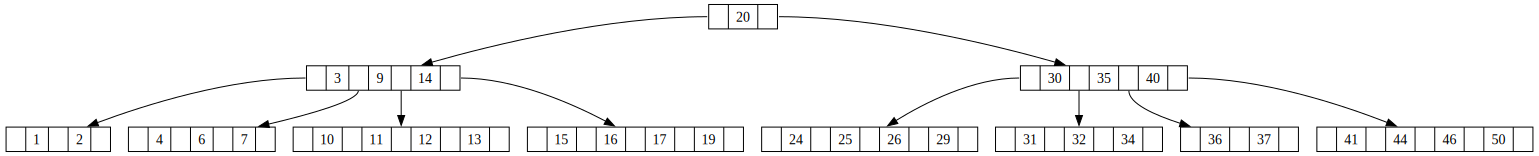

In [211]:
btree = ArbreB(2)
# btree.ajout(2)
# btree.ajout(11)
# btree.ajout(16)
# btree.ajout(21)
# # btree.ajout(9)
for i in range(51):
    k = randint(1,50)
    print("ajout de cle ",k)
    btree.ajout(k)

# if btree.recherche(16):
#     print("j'ai trouve !")
# else:
#     print("recherche echouee ?")

dot = visualiser_arbre(btree)
dot
# print(dot.source) 

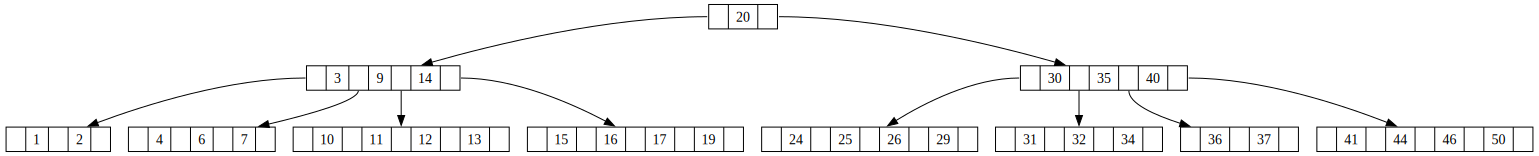

In [212]:
duplique = btree._duplique()
dot2 = visualiser_arbre(duplique)
dot2

[2] 5
[2] 6
[2] 7
[2, 5] 8
[2, 5] 9
[2, 5] 10
[2, 5, 8] 11
[2, 5, 8] 12
[2, 5, 8] 13
[2, 5, 8, 11] 14
[2, 5, 8, 11] 15
[2, 5, 8, 11] 16
[8] 17
[11, 14] 17
[8] 18
[11, 14] 18
[8] 19
[11, 14] 19
[8] 20
[11, 14, 17] 20
[8] 21
[11, 14, 17] 21
[8] 22
[11, 14, 17] 22
[8] 23
[11, 14, 17, 20] 23
[8] 24
[11, 14, 17, 20] 24
[8] 25
[11, 14, 17, 20] 25
[8, 17] 26
[20, 23] 26
[8, 17] 27
[20, 23] 27
[8, 17] 28
[20, 23] 28
[8, 17] 29
[20, 23, 26] 29


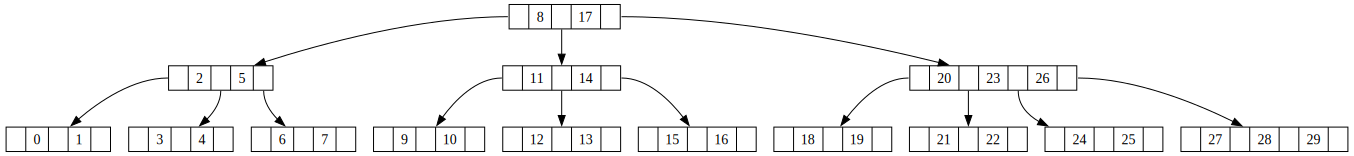

In [213]:
btree3 = ArbreB(2)
for i in range(30):
    # k = randint(1,20)
    # print("ajout de cle ",k)
    btree3.ajout(i)
dot3 = visualiser_arbre(btree3)
dot3

[8, 17] 25
[20, 23, 26] 25


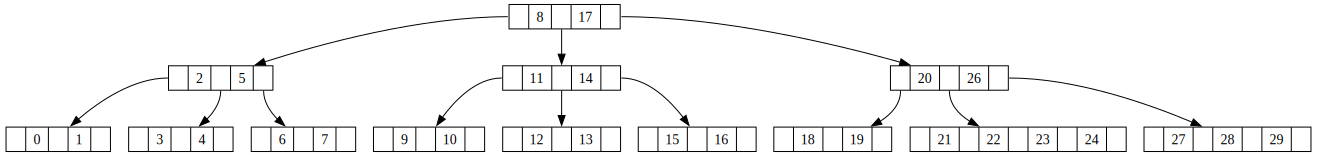

In [214]:
btree3.suppression(25)
dot4 = visualiser_arbre(btree3)
dot4

# Arbres-B - Version 2
Sources : Sedgewick Wayne - Algorithms 4th edition

Avec clés sentinelles : pas de doublon de clés dans l'arbre mais copies de clés dans les noeuds internes pour guider la recherche.
- Noeuds internes : copie de clé + pages
- Noeuds externes : clé réelle

Pour un arbre d'ordre m avec m pair :
- Noeuds : m/2 <= k <= m-1 clés
- Racine : 2 <= k <= m-1 clés

## Arbre-B et PageB V2 <a class="anchor" id="btree2"></a>                                                                                                                                  
#### [Retour](#menu) 

In [215]:
# def visualiser_arbre2(arbreB):
#     dot = Digraph()
#     index = 0

#     def case(indice, estDerniereCle, cle=None):
#         buffer = ""
#         if cle is None:
#             buffer += "<f" + str(indice) + "> "
#         else:
#             buffer += "<f" + str(indice) + "> " + str(cle)
#         if estDerniereCle:
#             buffer += "|"
#         return buffer
    
#     def traverse2(pageB):
#         nonlocal index

#         if pageB is None:
#             return

#         bufferRac = ""
#         for i in range(len(arbreB.cles)):
#             if i == len(arbreB.cles)-1 : # cas de la derniere cle
#                 bufferRac += case(len(arbreB.cles)-1, True, arbreB.cles[-1])
#             else:
#                 bufferRac += case(i, False, arbreB.cles[i])
#         dot.node(str(index), bufferRac)
#         index += 1
        
#         for i in range(len(arbreB.enfants)):
#             traverse2(arbreB.enfants[i])
    
#     traverse2(arbreB.racine)
#     return dot

In [216]:
# class PageB:
#     def __init__(self, cles=[-1], estExterne=True):
#         self.cles = cles # nbCles noeud : entre m/2 et m-1, nbCles racine : entre 2 et m-1
#         self.enfants = []
#         self.parent = None
#         self.estExterne = estExterne

#     def estPageExterne(self):
#         return self.estExterne
    
#     def estPagePleine(self, nbMaxCles):
#         return len(self.cles) == nbMaxCles

#     def estDansPage(self, cle):
#         return cle in self.cles
    
#     def pageSuivante(self, cle):
#         """ Retourne la page suivante (enfant de la page self) qui pourrait
#             contenir la cle cle.
#             Hypothese : self n'est pas une page externe (sinon pas de page suivante)
#         """
#         assert not self.estExterne, "pageSuivante : page externe, pas de page suivante!"
#         for i in range(len(self.enfants)):
#             if cle < self.cles[i]:
#                 return self.enfants[i]
                
#     def ajoutPageExterne(self, cle):
#         """ Ajoute la cle cle dans la page externe self.
#         """
#         assert self.estPageExterne(), "ajoutPageExterne : pas une page externe!"
#         self.cles.append(cle)
#         self.cles.sort()

#     def eclatement(self):
#         """ Deplace la grande moitie des cles dans la page self vers une
#             nouvelle page et retourne cette nouvelle page.
#         """
#         moitie = len(self.cles)//2
#         petiteMoitie = self.cles[:moitie]
#         grandeMoitie = self.cles[moitie:]
#         self.cles = petiteMoitie
#         return PageB(grandeMoitie)
    
    
# class ArbreB:
#     def __init__(self, ordre):
#         assert ordre % 2 == 0, "Par convention, veuillez entrer un ordre pair!"
#         self.racine = PageB()
#         self.NBCLESMAX = ordre - 1
        
 
#     def recherche(self, cle):
#         """ Retourne vrai si cle est dans l'arbre-B self en
#             cherchant dans les pagesB de l'arbre-B a l'aide
#             de la fonction _recherche(pageB, cle).
#         """
#         return self._recherche(self.racine, cle)
    
#     def _recherche(self, page:PageB, cle):
#         """ Retourne vrai si la cle est dans l'arbre-B self en
#             cherchant si la cle est dans une pageB de l'arbre.
#         """
#         if page.estPageExterne():
#             return page.recherchePage(cle)
#         else:
#             return self._recherche(page.pageSuivante(cle), cle)
        

#     def ajout(self, cle):
#         if self.estVide():
#             self.racine = PageB([cle])
#             return
#         else:
#             self.racine.cles.append(cle)
#             if self.racine.estPagePleine(self.NBCLESMAX):
#                 petiteMoitie = self.racine
#                 grandeMoitie = self.racine.eclatement()
#                 self.racine = PageB(petiteMoitie, False)
#                 self.racine.cles.extend(grandeMoitie)




